In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import PcmPy as pcm
import warnings
import os


## Variance partitioning for bivariate linear regression
We consider $y$ and regressors $x_1$ and $x_2$ in the bivariate linear regression model. 

The results are completely dependent on the three correlation between the variables: 
$r_{12}=corr(x_1,x_2)$
$r_{y1}=corr(x_1,y)$, and $r_{y2}=corr(x_2,y)$.

We are interested when the $R^2$ for the combined model is more or less than the sum of the individual models. 


In [2]:
from sympy import sqrt
# We can only have combinations of the three correlations, for which
# the determinant is non-negative.
ry1,ry2,r12=sym.symbols('ry1,ry2,r12')
F = sym.Matrix([[1, ry1, ry2],[ry1,1,r12],[ry2,r12,1]])
F.det()


-r12**2 + 2*r12*ry1*ry2 - ry1**2 - ry2**2 + 1

In [3]:
# What is R2 for the full model?
# First determine inv(X'X)
XX = sym.Matrix([[1, r12],[r12,1]])
XY = sym.Matrix([[ry1, ry2]])
XX.inv()

Matrix([
[   1/(1 - r12**2), -r12/(1 - r12**2)],
[-r12/(1 - r12**2),    1/(1 - r12**2)]])

In [4]:
# Then compute the R2 for the full model
XY @ XX.inv() @ XY.T

Matrix([[ry1*(-r12*ry2/(1 - r12**2) + ry1/(1 - r12**2)) + ry2*(-r12*ry1/(1 - r12**2) + ry2/(1 - r12**2))]])

So in summary 

$$
R^2_{12} = \frac{2 r_{y1} r_{y2} r_{12} - r_{y1}^2 - r_{y1}^2}{r_{12}^2 -1}
$$ 

## Where do we get suppression? 
The determinant tells us whether the combination of correlations is valid or not. If the determinant is negative, then the combination of correlations is impossible (correlation matrices need to be non-negative definite).

In [5]:
def calc_r2(r_y1, r_y2, r12):
    """
    Calculate the R^2 for the full model given the individual correlations
    and the correlation between the predictors.

    Args:
        r_y1 : float : Correlation of first predictor with the outcome
        r_y2 : float : Correlation of second predictor with the outcome
        r12 : float : Correlation between the two predictors

    Returns:
        RY12:  R^2 for the full model

    """
    RY12 = (2 * r_y1 * r_y2 * r12 - r_y1**2 - r_y2**2) / (r12**2 - 1)
    DET = 1 - r_y1**2 - r_y2**2 - r12**2 + 2 * r_y1 * r_y2 * r12
    return RY12, DET


In [6]:
# Sanity check if this is ok
ry1 = 0.8
ry2 = 0
r12 = 0.5

# Analytical answer
r2,det= calc_r2(ry1, ry2, r12)
print(f"R^2: {r2:2.3f}, Sum: {ry1**2 + ry2**2:2.3f}, DET: {det}")

XX = np.array([[1, r12],[r12,1]])
XY = np.array([[ry1, ry2]])
b = np.linalg.inv(XX) @ XY.T
R2 = b.T @ XX @ b
print(f'R2 {R2}')


R^2: 0.853, Sum: 0.640, DET: 0.10999999999999988
R2 [[0.85333333]]


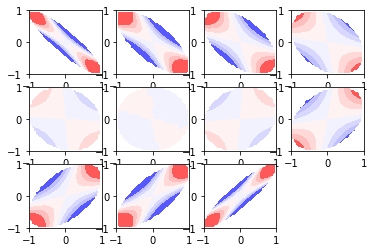

In [7]:
# Make surface plots
fig = plt.figure()
RY1, RY2 = np.meshgrid(np.linspace(-1,1,40),np.linspace(-1,1,40))
R12 = np.linspace(-0.9,0.9,11)
R2diff = np.zeros((len(R12),RY1.shape[0],RY1.shape[1]))
# Look at different levels of R12 and plot the space in terms of suppression / redudna
for i,r12 in enumerate(R12):
    RY12, DET = calc_r2(RY1, RY2, r12)
    RY12[DET<0] = np.nan # Kill stuff outside the ellipse
    plt.subplot(3,4,i+1)
    R2diff[i] = RY1**2 + RY2**2 - RY12
    plt.contourf(RY1,RY2,R2diff[i],levels=[-1,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,1],cmap='bwr')


### Occurance of suppression and redundancy
Look at suppression (negative values) and redundancy (positive values) across the entire volume of the correlations space
We see that suppression is as prevalent as redundancy. 

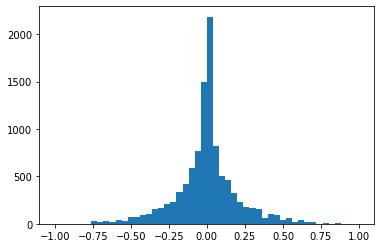

In [8]:
a= plt.hist(R2diff.flatten(), bins=50, range=(-1,1))

### Plot as a colors 3d-surface
To get the out surface of the area, we need to calculate where the determiant is zero - this is a cubic problem   

In [9]:
from numpy import sqrt, cos, sin,arccos, pi
def quadratic(a, b, c):
    D = b ** 2 - 4 * a * c
    x = (-b - sqrt(D)) / (2 * a)
    return x


def cubic(a, b, c, d):
    if np.abs(a)<1e-10:
        return quadratic(b,c,d)
    solutions = []
    p = (3 * a * c - b ** 2) / (3 * a ** 2)
    q = (2 * b ** 3 - 9 * a * b * c + 27 * a ** 2 * d) / (27 * a ** 3)
    solution = np.zeros(3)
    for n in range(3):
        solution[n]=((2 * sqrt(-p / 3) * cos(arccos((-3 * q) * sqrt(-3 * p) / (2 * p ** 2)) / 3 + 2 * pi * n / 3))
                        - (b / (3 * a)))
    if a < 0:
        return solution[0]
    else:
        return solution[2]


In [10]:
#
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()

a = 2*cos(v)*sin(u)*sin(v)*sin(v)*cos(u)
l = np.empty((len(u),))

for i in range(len(u)):
    l[i] = cubic(a[i],-1,0,1)
pass
RY1 = l*np.cos(u)*np.sin(v)
RY2 = l*np.sin(u)*np.sin(v)
R12 = l*np.cos(v)

RY12 = (2*RY1*RY2*R12 - RY1**2 - RY2**2)/(R12**2-1)
RY12[np.abs(R12)==1] = 0
d = RY1**2+RY2**2-RY12 # Difference between combined and sum of single

tri = mtri.Triangulation(u, v)
xt = RY1[tri.triangles]
yt = RY2[tri.triangles]
zt = R12[tri.triangles]
dt = d[tri.triangles].mean(axis=1)
verts = np.stack((xt, yt, zt), axis=-1)

/var/folders/vh/tsrrmndj3kj8fm3m4p51k3nc0000gn/T/ipykernel_67985/4276179947.py:17: RuntimeWarning: divide by zero encountered in divide
  RY12 = (2*RY1*RY2*R12 - RY1**2 - RY2**2)/(R12**2-1)
/var/folders/vh/tsrrmndj3kj8fm3m4p51k3nc0000gn/T/ipykernel_67985/4276179947.py:17: RuntimeWarning: invalid value encountered in divide
  RY12 = (2*RY1*RY2*R12 - RY1**2 - RY2**2)/(R12**2-1)


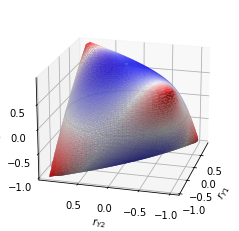

In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LightSource

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
avg_z = verts[:, :, 2].mean(axis=1)
cmap = plt.get_cmap('bwr')

colors = cmap((dt+1)/2) # -np.min(dt))/(np.max(dt)-np.min(dt)))
ls = LightSource(azdeg=10.0, altdeg=-90)
polyc = Poly3DCollection(verts,shade=True,facecolors=colors,lightsource=ls)
# average over the three points of each triangle
# polyc.set_facecolor(plt.cm.viridis(avg_z))
# polyc.set_edtgecolor('k')
ax.add_collection3d(polyc)
ax.auto_scale_xyz(xt, yt, zt)
uu = np.linspace(0, 2 * np.pi, 100)
ax.plot(cos(uu)*1,sin(uu)*1,np.zeros(uu.shape),color='k', zorder=3, alpha=0.05)
ax.set_xlabel('$r_{Y1}$')
ax.set_ylabel('$r_{Y2}$')
ax.set_zlabel('$r_{12}$')
ax.set_xticks(np.arange(-1, 1, 0.5))
ax.set_yticks(np.arange(-1, 1, 0.5))
ax.set_zticks(np.arange(-1, 1, 0.5))
ax.set_xlim([-1.05, 1.05])
ax.set_xlim([-1.05, 1.05])
ax.set_xlim([-1.05, 1.05])
ax.view_init(20, -165)

filename = 'surface_plot.pdf'
plt.savefig(filename, bbox_inches='tight')

In [14]:
def get_vectors(r12, rY1, rY2):
    X1 = np.array([1, 0, 0])
    X2 = np.array([r12, np.sqrt(1 - r12**2), 0])
    a = rY1
    b = (rY2 - rY1 * r12) / np.sqrt(1 - r12**2)
    c = np.sqrt(1 - a**2 - b**2)
    Y = np.array([a, b, c])
    return X1, X2, Y


def plot_projection(r12, rY1, rY2,ax = None):
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')

    X1, X2, Y = get_vectors(r12, rY1, rY2)

    # Plot the regressors and data as vectors
    ax.quiver(0, 0, 0, Y[0], Y[1], Y[2], length=1, arrow_length_ratio=0.05, colors='k')
    ax.quiver(0, 0, 0, X1[0], X1[1], X1[2], length=1, arrow_length_ratio=0.05, colors='k')
    ax.quiver(0, 0, 0, X2[0], X2[1], X2[2], length=1, arrow_length_ratio=0.05, colors='k')

    # These are the predicted values for the single regressions
    P1 = X1 * (X1.T @ Y)
    P2 = X2 * (X2.T @ Y)
    # Calculate matrix and predicted values for the joint regression
    X = np.c_[X1,X2]
    beta = np.linalg.pinv(X) @ Y
    Q = X @ beta
    # get the contributions of each of the two regressors to the joint regression
    Q1 = X1 * beta[0]
    Q2 = X2 * beta[1]

    # the line projected onto <x1, X2> plane
    ax.plot(P1[0], P1[1], P1[2], 'o',color='g')
    ax.plot(P2[0], P2[1], P2[2], 'o',color='g')
    ax.plot(Q[0], Q[1], Q[2], 'o',color='g')
    ax.plot([0, Q[0]], [0, Q[1]], [0,Q[2]], linestyle='-', color='g', linewidth=1.5)
    ax.plot([Q1[0], Q[0]], [Q1[1],Q[1]], [Q1[2],Q[2]], linestyle='--', color='g', linewidth=1)
    ax.plot([Q2[0], Q[0]], [Q2[1],Q[1]], [Q2[2],Q[2]], linestyle='--', color='g', linewidth=1)

    ax.plot([Y[0], P1[0]], [Y[1],P1[1]], [Y[2],P1[2]], linestyle='--', color='b', linewidth=1)
    ax.plot([Y[0], P2[0]], [Y[1],P2[1]], [Y[2],P2[2]], linestyle='--', color='b', linewidth=1)
    ax.plot([Y[0], Q[0]], [Y[1],Q[1]], [Y[2],Q[2]], linestyle='--', color='b', linewidth=1)

    ax.set_xlim([0,1.05])
    ax.set_ylim([0,1.05])
    ax.set_zlim([0,1.05])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    R2,det = calc_r2(rY1,rY2,r12)
    print(det)
    title_str= f'{r12} {rY1} {rY2} {R2:2.2f} vs. {rY1**2 + rY2**2:2.2f} '
    ax.set_title(title_str)



0.4375
0.2940000000000001
0.278


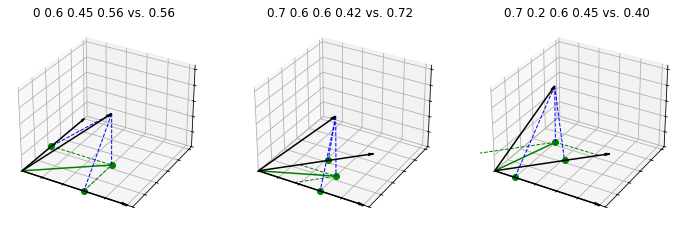

In [16]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,3,1,projection='3d')
plot_projection(0,0.6,0.45,ax1)
ax2 = fig.add_subplot(1,3,2,projection='3d')
plot_projection(0.7,0.6,0.6,ax2)
ax3 = fig.add_subplot(1,3,3,projection='3d')
plot_projection(0.7,0.2,0.6,ax3)

filename = 'projections.pdf'
plt.savefig(filename, bbox_inches='tight')